In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [1]:


import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras.applications.xception as xception
import zipfile
import sys
import time
import tensorflow.keras as keras
import tensorflow as tf
import re

from PIL import Image
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
from keras.layers.experimental.preprocessing import Normalization
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.layers import Lambda
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
IMAGE_WIDTH = 320
IMAGE_HEIGHT = 320
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3


# Path where our data is located
base_path = "/content/drive/MyDrive/clasificador/dataset/garbage_classification/"

# Dictionary to save our 12 classes
categories = {0: 'paper', 1: 'cardboard', 2: 'plastic', 3: 'metal', 4: 'trash', 5: 'battery',
              6: 'shoes', 7: 'clothes', 8: 'green-glass', 9: 'brown-glass', 10: 'white-glass',
              11: 'biological'}

print('defining constants successful!')

defining constants successful!


In [34]:
# Add class name prefix to filename. So for example "/paper104.jpg" become "paper/paper104.jpg"
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])

    filenames_list = filenames_list  +filenames
    categories_list = categories_list + [category] * len(filenames)

df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print('number of elements = ' , len(df))

number of elements =  15515


In [19]:
import os
import pandas as pd
import re

# Function to add class name prefix to filename
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d", x).start()] + '/' + x)
    return df

# Maximum number of samples per class
max_samples_per_class = 200

# List containing all the filenames in the dataset
filenames_list = []
# List to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])

    # Limit the number of samples per class to max_samples_per_class
    sampled_filenames = filenames[:max_samples_per_class]

    filenames_list = filenames_list + sampled_filenames
    categories_list = categories_list + [category] * len(sampled_filenames)

df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print('number of elements =', len(df))

number of elements = 2400


In [6]:
df.head()

,filename,category
0,biological/biological774.jpg,11
1,paper/paper951.jpg,0
2,paper/paper1047.jpg,0
3,battery/battery376.jpg,5
4,paper/paper482.jpg,0


shoes/shoes1578.jpg


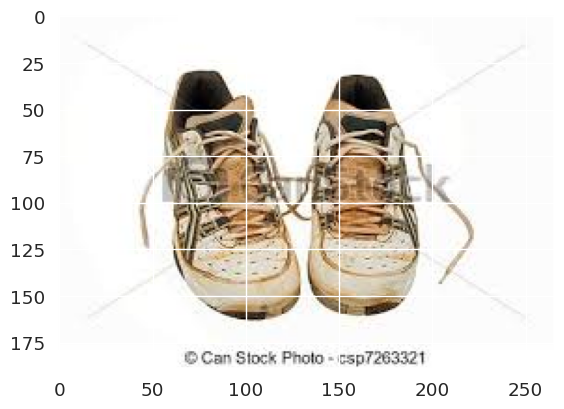

In [35]:
# see sample image, you can run the same cell again to get a different image
random_row = random.randint(0, len(df)-1)
sample = df.iloc[random_row]
randomimage = image.load_img(base_path +sample['filename'])
print(sample['filename'])
plt.imshow(randomimage)

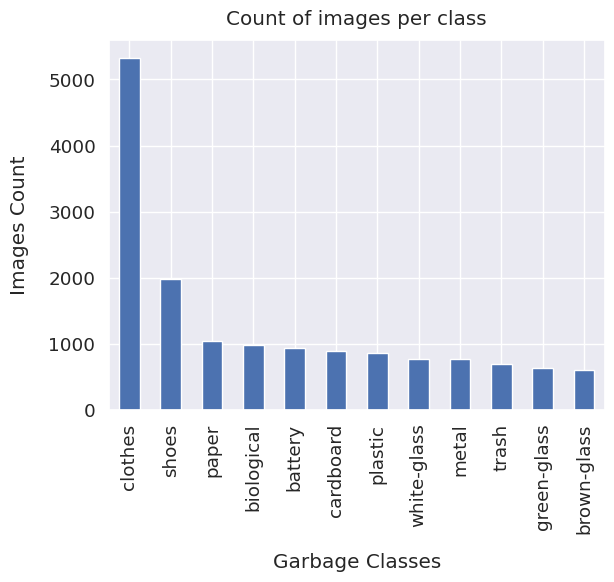

In [36]:
df_visualization = df.copy()
# Change the catgegories from numbers to names
df_visualization['category'] = df_visualization['category'].apply(lambda x:categories[x] )

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Garbage Classes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of images per class", y=1.02);

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
import keras.applications.xception as xception
from tensorflow.keras import applications
from tensorflow.keras.applications.imagenet_utils import preprocess_input

#Red = applications.resnet50.ResNet50(include_top=False,
#              weights='imagenet',   input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS) )

#for layer in Red.layers  :
 #  layer.trainable = False

#for layer in Red.layers:
#    if 'BatchNormalization' in str(layer):
#        layer.trainable = True
#   print(layer, layer.trainable)
Red=applications.vgg16.VGG16(include_top=False,
              weights='imagenet',  input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS) )

for layer in Red.layers:
        layer.trainable = False
for layer in Red.layers:
        print(layer, layer.trainable)
model = Sequential()
model.add(keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))

#create a custom layer to apply the preprocessing

def our_preprocessing_function(img):
    return preprocess_input(img, mode='caffe')



model.add(Red)
#model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dropout(0.15 ))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(categories), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()

58889256/58889256 [==============================] - 1s 0us/step
<keras.src.engine.input_layer.InputLayer object at 0x7c092e3dee00> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c089ef10d00> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c08a40e6a10> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7c089ef02bf0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c08a414fb20> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c08a40b52a0> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7c089e660370> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c089ef02290> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c089ef008b0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c089e661de0> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7c089e662ad0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c0

In [37]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
import keras.applications.xception as xception

xception_layer = xception.Xception(include_top = False, input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS),
                       weights = 'imagenet')

# We don't want to train the imported weights
xception_layer.trainable = False


model = Sequential()
model.add(keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))

#create a custom layer to apply the preprocessing
def xception_preprocessing(img):
  return xception.preprocess_input(img)

model.add(Lambda(xception_preprocessing))

model.add(xception_layer)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(len(categories), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 320, 320, 3)       0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 12)                24588     
                                                                 
Total params: 20886068 (79.67 MB)
Trainable params: 24588 (96.05 KB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


In [38]:


early_stop = EarlyStopping(patience = 2, verbose = 1, monitor='val_categorical_accuracy' , mode='max', min_delta=0.001, restore_best_weights = True)

callbacks = [early_stop]

print('call back defined!')



call back defined!


In [39]:
#Change the categories from numbers to names
df["category"] = df["category"].replace(categories)

# We first split the data into two sets and then split the validate_df to two sets
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print('train size = ', total_train , 'validate size = ', total_validate, 'test size = ', test_df.shape[0])

train size =  12412 validate size =  1551 test size =  1552


In [40]:
batch_size=64

train_datagen = image.ImageDataGenerator(
    #preprocessing_function=preprocess_input,
    ###  Augmentation Start  ###

    rotation_range=30,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2

    ##  Augmentation End  ###
)

train_generator = train_datagen.flow_from_dataframe(

    train_df,
    base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 12412 validated image filenames belonging to 12 classes.


In [41]:


validation_datagen = image.ImageDataGenerator()#preprocessing_function = our_preprocessing_function)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)



Found 1551 validated image filenames belonging to 12 classes.


In [42]:
#validation_steps=total_validate//batch_size,
#steps_per_epoch=total_train//batch_size,

EPOCHS = 20
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/20
193/193 [==============================] - 2724s 14s/step - loss: 0.7287 - categorical_accuracy: 0.8081 - val_loss: 0.3608 - val_categorical_accuracy: 0.9030
Epoch 2/20
193/193 [==============================] - 396s 2s/step - loss: 0.3557 - categorical_accuracy: 0.8989 - val_loss: 0.2793 - val_categorical_accuracy: 0.9160
Epoch 3/20
193/193 [==============================] - 403s 2s/step - loss: 0.2953 - categorical_accuracy: 0.9140 - val_loss: 0.2506 - val_categorical_accuracy: 0.9238
Epoch 4/20
193/193 [==============================] - 395s 2s/step - loss: 0.2659 - categorical_accuracy: 0.9202 - val_loss: 0.2354 - val_categorical_accuracy: 0.9277
Epoch 5/20
193/193 [==============================] - 404s 2s/step - loss: 0.2440 - categorical_accuracy: 0.9257 - val_loss: 0.2250 - val_categorical_accuracy: 0.9329
Epoch 6/20
193/193 [==============================] - 396s 2s/step - loss: 0.2308 - categorical_accuracy: 0.9307 - val_loss: 0.2247 - val_categorical_accuracy: 0.9

In [43]:


model.save_weights("pesosxception.h5")



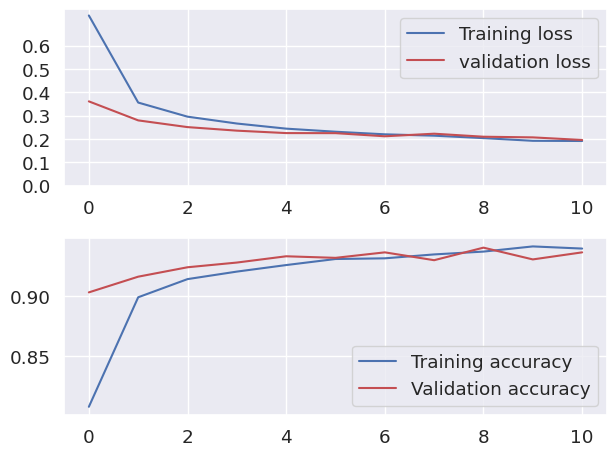

In [44]:


fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()



In [45]:


test_datagen = image.ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False
)



Found 1552 validated image filenames belonging to 12 classes.


In [46]:


filenames = test_generator.filenames
nb_samples = len(filenames)

_, accuracy = model.evaluate_generator(test_generator, nb_samples)

print('accuracy on test set = ',  round((accuracy * 100),2 ), '% ')



<ipython-input-46-0e330b4c9c1d>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, accuracy = model.evaluate_generator(test_generator, nb_samples)


accuracy on test set =  94.14 % 


In [47]:
# We defined at the beginning of this notebook a dictionary that maps the categories number to names, but the train generator
# generated it's own dictionary and it has assigned different numbers to our categories and the predictions made by the model
# will be made using the genrator's dictionary.

gen_label_map = test_generator.class_indices
gen_label_map = dict((v,k) for k,v in gen_label_map.items())
print(gen_label_map)

{0: 'battery', 1: 'biological', 2: 'brown-glass', 3: 'cardboard', 4: 'clothes', 5: 'green-glass', 6: 'metal', 7: 'paper', 8: 'plastic', 9: 'shoes', 10: 'trash', 11: 'white-glass'}


<ipython-input-48-4748394ce0f2>:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator, nb_samples)


              precision    recall  f1-score   support

     battery       0.94      0.99      0.96        97
  biological       0.97      0.98      0.98       108
 brown-glass       0.92      0.86      0.89        51
   cardboard       0.99      0.87      0.93        79
     clothes       0.99      0.98      0.99       520
 green-glass       0.89      0.87      0.88        63
       metal       0.80      0.89      0.84        85
       paper       0.89      0.95      0.92        96
     plastic       0.88      0.85      0.86       101
       shoes       0.94      0.99      0.97       215
       trash       0.98      0.92      0.95        61
 white-glass       0.84      0.78      0.81        76

    accuracy                           0.94      1552
   macro avg       0.92      0.91      0.91      1552
weighted avg       0.94      0.94      0.94      1552



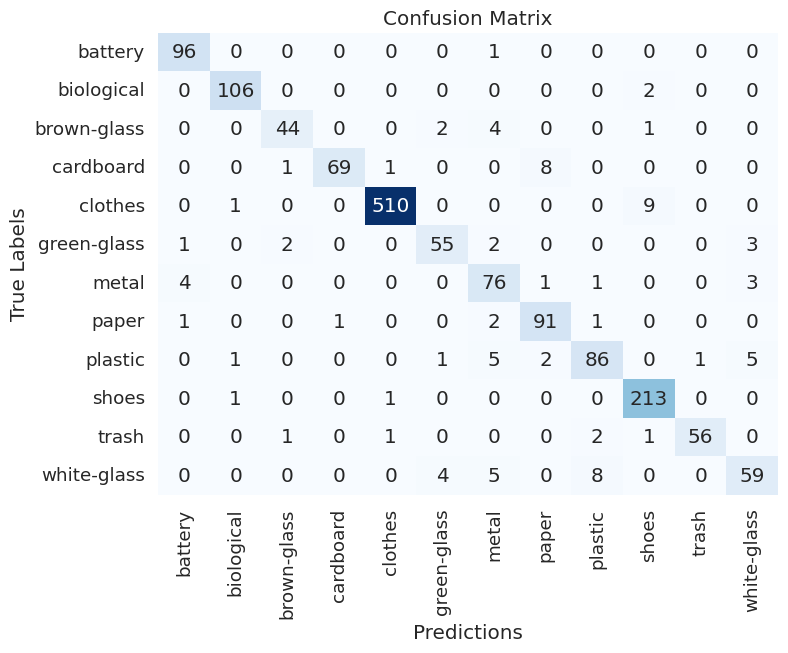

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# get the model's predictions for the test set
preds = model.predict_generator(test_generator, nb_samples)

# Get the category with the highest predicted probability, the prediction is only the category's number and not name
preds = preds.argmax(1)

# Convert the predicted category's number to name
preds = [gen_label_map[item] for item in preds]

# Convert the pandas dataframe to a numpy matrix
labels = test_df['category'].to_numpy()

# Print classification report
print(classification_report(labels, preds))

# Create confusion matrix
conf_matrix = confusion_matrix(labels, preds)

# Plot confusion matrix with seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(labels), yticklabels=np.unique(labels))

plt.title('Confusion Matrix')
plt.xlabel('Predictions')
plt.ylabel('True Labels')
plt.show()


In [ ]:
print(test_df["category"].value_counts())

clothes        551
shoes          195
paper          122
battery         96
biological      93
cardboard       88
plastic         79
white-glass     78
trash           66
metal           65
green-glass     60
brown-glass     59
Name: category, dtype: int64
